In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fetch historical stock data
def fetch_stock_data(ticker, start_date, end_date):
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

apple_data = fetch_stock_data("AAPL", "2010-01-01", "2025-01-01")
print(apple_data.shape)
apple_data.head()

Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed

(3774, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447412,6.462174,6.398305,6.429938,493729600
2010-01-05,6.458557,6.495010,6.424514,6.465185,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344078,6.386858,6.297984,6.379326,477131200
2010-01-08,6.386252,6.386855,6.298283,6.335639,447610800


In [2]:
apple_data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447412,6.462174,6.398305,6.429938,493729600
2010-01-05,6.458557,6.495010,6.424514,6.465185,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344078,6.386858,6.297984,6.379326,477131200
2010-01-08,6.386252,6.386855,6.298283,6.335639,447610800
...,...,...,...,...,...
2024-12-24,258.200012,258.209991,255.289993,255.490005,23234700
2024-12-26,259.019989,260.100006,257.630005,258.190002,27237100


In [3]:
import os
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

def save_plot(name):
    plt.savefig(os.path.join(plot_dir, name), dpi=300)

<Axes: title={'center': 'AAPL Stock Price'}, xlabel='Date'>

<Figure size 500x300 with 0 Axes>

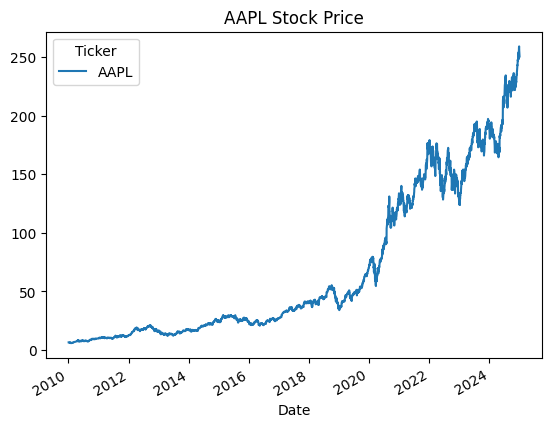

In [4]:
plt.figure(figsize=(5, 3))
apple_data["Close"].plot(title="AAPL Stock Price")

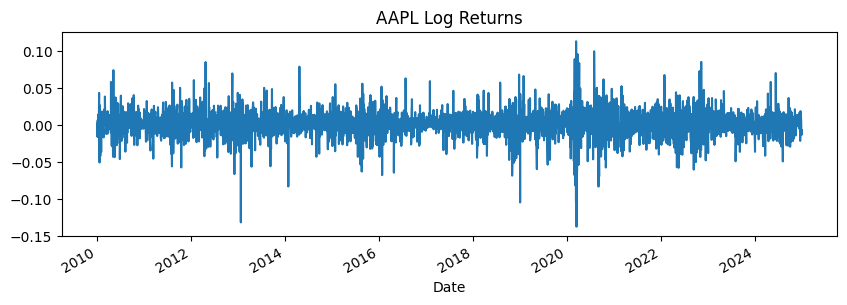

In [5]:
# log returns of AAPL
apple_data['returns'] = apple_data['Close'].pct_change()
apple_data['log_returns'] = np.log(1 + apple_data['returns'])
plt.figure(figsize=(10, 3))
apple_data['log_returns'].plot(title="AAPL Log Returns")
save_plot("aapl_log_returns.png")
plt.show()

# SF1

### Notice non-normality and mild assymetry

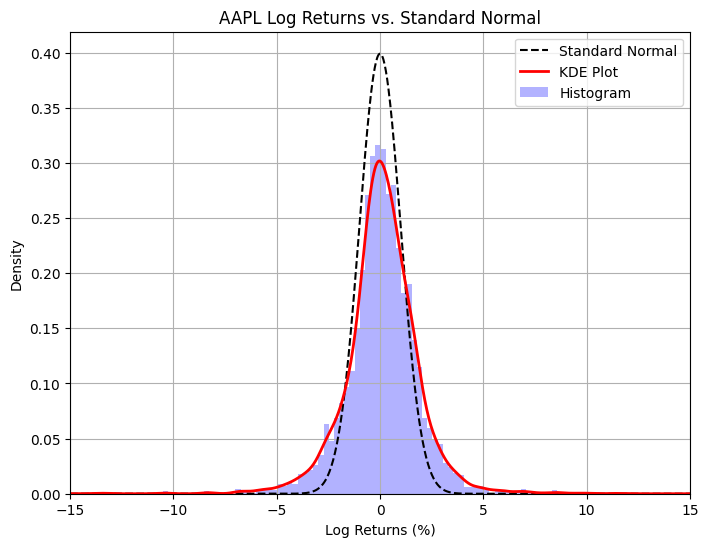

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# remove first row (NaN), and * 100 to get percentage
log_returns = apple_data.iloc[1:]['log_returns'] * 100

x = np.linspace(-15, 15, 1000)
y = norm.pdf(x, 0, 1)  # Standard normal distribution N(0,1)

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='black', linestyle="dashed", label="Standard Normal")

# Pandas KDE plot
log_returns.plot.kde(color='red', linewidth=2, label="KDE Plot")

# Histogram
plt.hist(log_returns, bins=100, color='blue', alpha=0.3, density=True, label="Histogram")
plt.title("AAPL Log Returns vs. Standard Normal")
plt.xlabel("Log Returns (%)")
plt.xlim(-15, 15)
plt.legend()
plt.grid()
save_plot("aapl_log_returns_kde.png")
plt.show()

### Notice non-normal with heavy tails

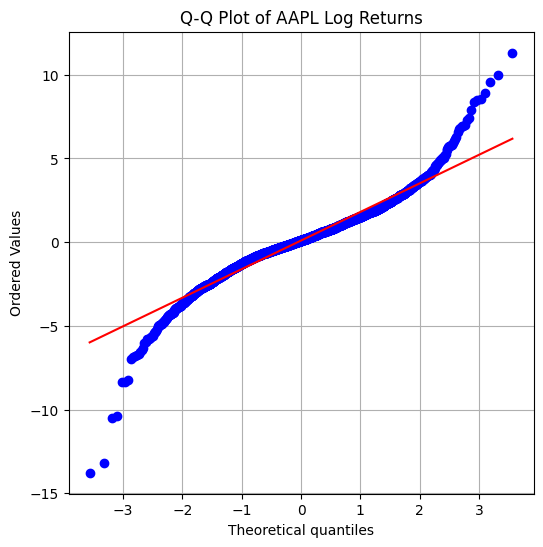

In [7]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("Q-Q Plot of AAPL Log Returns")
plt.grid()
save_plot("aapl_log_returns_qq.png")
plt.show()

### strong leptokurticity

In [8]:
# compute sample kurtosis
kurtosis = log_returns.kurtosis()
print(f"Sample kurtosis: {kurtosis}")

Sample kurtosis: 5.454349983942186


(SF1) The unconditional distribution of returns (at a daily or shorter time scale) is
markedly non-normal with heavy tails and possibly mild asymmetry.

(SF2) Returns are serially uncorrelated.

(SF3) Volatility is clustered and persistent.

(SF4) Aggregational Gaussianity.

## (SF2), no serial correlation 
which is effectively a statement about market efficiency, and related to martingale (independent increment)

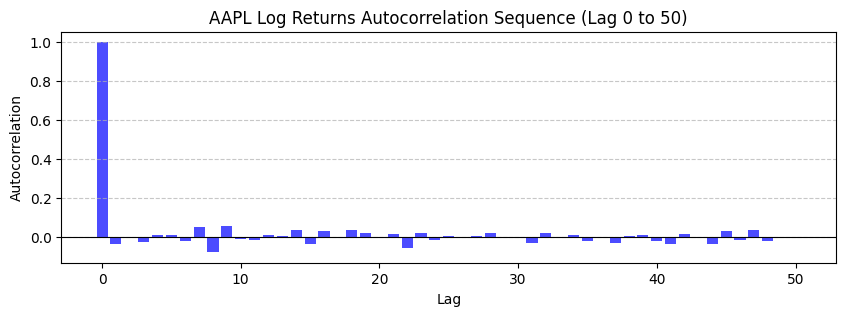

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute autocorrelation sequence
def autocorr_numpy(x, lags):
    x = x - np.mean(x)  # Demean the series
    result = np.correlate(x, x, mode='full')  # Compute full autocorrelation
    result = result[result.size // 2:]  # Take the second half (positive lags)
    return result[:lags + 1] / result[0]  # Normalize by lag 0 value

# Compute ACS from lag 0 to 50
lags = 50
acs = autocorr_numpy(log_returns, lags)

# Plot ACS
plt.figure(figsize=(10, 3))
plt.bar(range(lags + 1), acs, width=0.8, color="blue", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("AAPL Log Returns Autocorrelation Sequence (Lag 0 to 50)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
save_plot("aapl_log_returns_acf.png")
plt.show()

## SF3 Clustered volatility

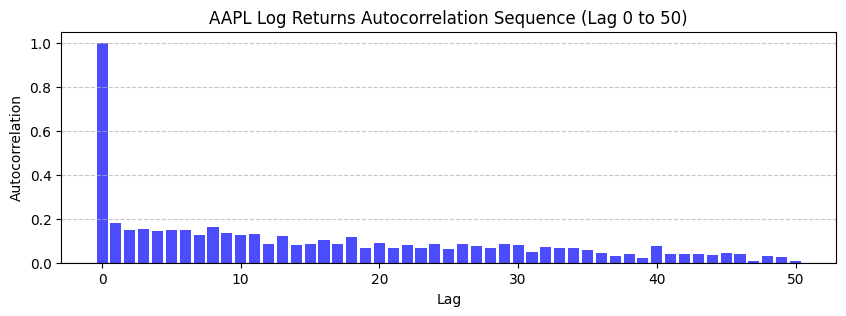

In [10]:
# plot absolute return
abs_returns = np.abs(log_returns)
acs = autocorr_numpy(abs_returns, lags)

# Plot ACS
plt.figure(figsize=(10, 3))
plt.bar(range(lags + 1), acs, width=0.8, color="blue", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("AAPL Log Returns Autocorrelation Sequence (Lag 0 to 50)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
save_plot("aapl_abs_returns_acf.png")
plt.show()

In [32]:
def plot_log_returns(returns, title, filename=None):
    returns = returns.dropna()
    # compare with normal of zero mean and same std
    x = np.linspace(returns.min(), returns.max(), 1000)
    y = norm.pdf(x, 0, returns.var()**0.5)          
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, color='black', linestyle='dashed', label='Standard Normal')
    returns.plot.kde(color='red', linewidth=2, label='KDE Plot')
    plt.hist(returns, bins=50, color='blue', alpha=0.3, density=True, label='Histogram')
    plt.title(title)
    plt.xlabel('Log Returns (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    if filename:
        save_plot(filename)


In [33]:
Week_returns = apple_data['log_returns'].iloc[1:].resample('W').sum() * 100
Month_returns = apple_data['log_returns'].iloc[1:].resample('M').sum() * 100
Year_returns = apple_data['log_returns'].iloc[1:].resample('Y').sum() * 100
Week_returns.shape, type(Week_returns), Month_returns.shape, type(Month_returns), Year_returns.shape, type(Year_returns)

/tmp/ipykernel_1954003/4022705241.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Month_returns = apple_data['log_returns'].iloc[1:].resample('M').sum() * 100
/tmp/ipykernel_1954003/4022705241.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  Year_returns = apple_data['log_returns'].iloc[1:].resample('Y').sum() * 100


((783,),
 pandas.core.series.Series,
 (180,),
 pandas.core.series.Series,
 (15,),
 pandas.core.series.Series)

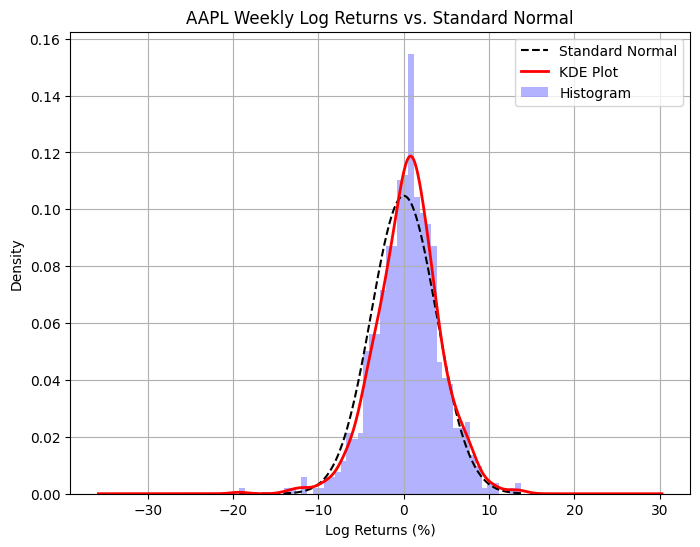

<Figure size 640x480 with 0 Axes>

In [34]:
plot_log_returns(Week_returns, "AAPL Weekly Log Returns vs. Standard Normal", "aapl_weekly_log_returns.png")

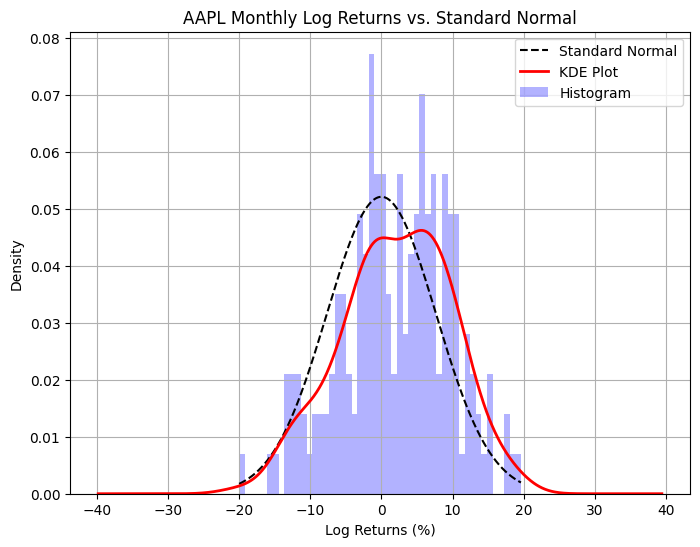

<Figure size 640x480 with 0 Axes>

In [35]:
plot_log_returns(Month_returns, "AAPL Monthly Log Returns vs. Standard Normal", "aapl_monthly_log_returns.png")

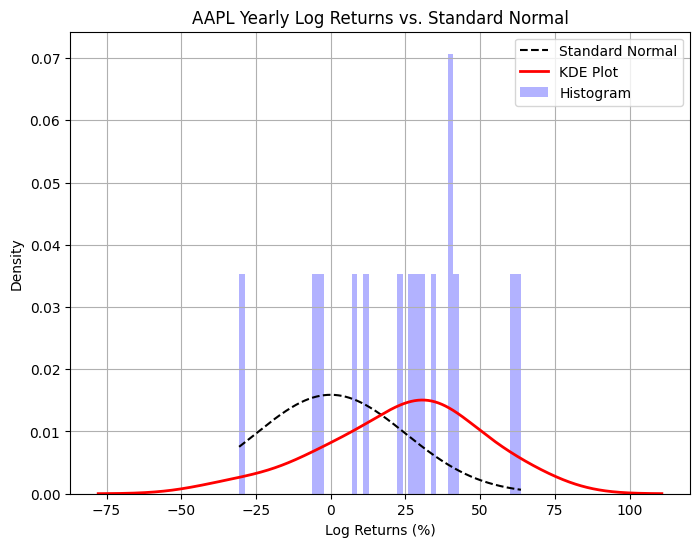

<Figure size 640x480 with 0 Axes>

In [36]:
plot_log_returns(Year_returns, "AAPL Yearly Log Returns vs. Standard Normal", "aapl_yearly_log_returns.png")